# Low-Rank Adaption of LLM

## Reference:
- Fine-tuning a GPT — LoRA. https://medium.com/@dataman-ai/fine-tune-a-gpt-lora-e9b72ad4ad3
- 当红炸子鸡 LoRA，是当代微调 LLMs 的正确姿势.https://zhuanlan.zhihu.com/p/618894919
- Two Essentials for ML Service-Level Performance Monitoring. https://towardsdatascience.com/two-essentials-for-ml-service-level-performance-monitoring-2637bdabc0d2
- Adapters: A Compact and Extensible Transfer Learning Method for NLP. https://medium.com/dair-ai/adapters-a-compact-and-extensible-transfer-learning-method-for-nlp-6d18c2399f62
- Supercharging Deep Learning: Exploring Model Parallelism, Data Parallelism, and Hybrid Parallelism in Distributed Training.https://medium.com/@chandu.bathula16/supercharging-deep-learning-exploring-model-parallelism-data-parallelism-and-hybrid-parallelism-834b119db91f
- Deep Learning Frameworks for Parallel and Distributed Infrastructures. https://towardsdatascience.com/scalable-deep-learning-on-parallel-and-distributed-infrastructures-e5fb4a956bef
- Fine-tuning a GPT — Prefix-tuning. https://medium.com/@dataman-ai/fine-tune-a-gpt-prefix-tuning-13c263e73141
- Prefix-Tuning: Optimizing Continuous Prompts for Generation. https://arxiv.org/pdf/2101.00190.pdf
- 《Prefix-Tuning: Optimizing Continuous Prompts for Generation》阅读笔记.https://zhuanlan.zhihu.com/p/386073664
- Foundations of NLP Explained Visually: Beam Search, How It Works.https://medium.com/towards-data-science/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24

## 1. Comparison with Other Existing Fine-Tuning Technique
### 1. Adapter layers introduce inference latency.
- Main Idea: Parameters are copied from pre-training + task-specific parameters for each task(without affecting previous one)
- processed **sequentially**, without *model parallelism*
- Structure:
  - inject two new adapter layer which is randomly initialized into original network.
    - the output of each sub-layer which contains <u>an attention layer and a feedforward layer</u> is fed into `layer normalization`.
    - each adapter layer is put after feed-forward layer and before the jump-connection add back.
    - jump-connection applied across two sub-layers.
  - Adapter layer:
    - it has an inner jump-connections
    - projection layer: map the feature size back to the input size
    - the `bottleneck` is located in the middle with small amount of parameters.
    - initalized randomly
    - During training, adapter layers is to change distribution of network's activations.
  - original network parameters are frozed.
- Notes:
  - FLOP: how many operations are needed to run the network.
- Brawback: without hardware parallelism, the model creates high inference latency.

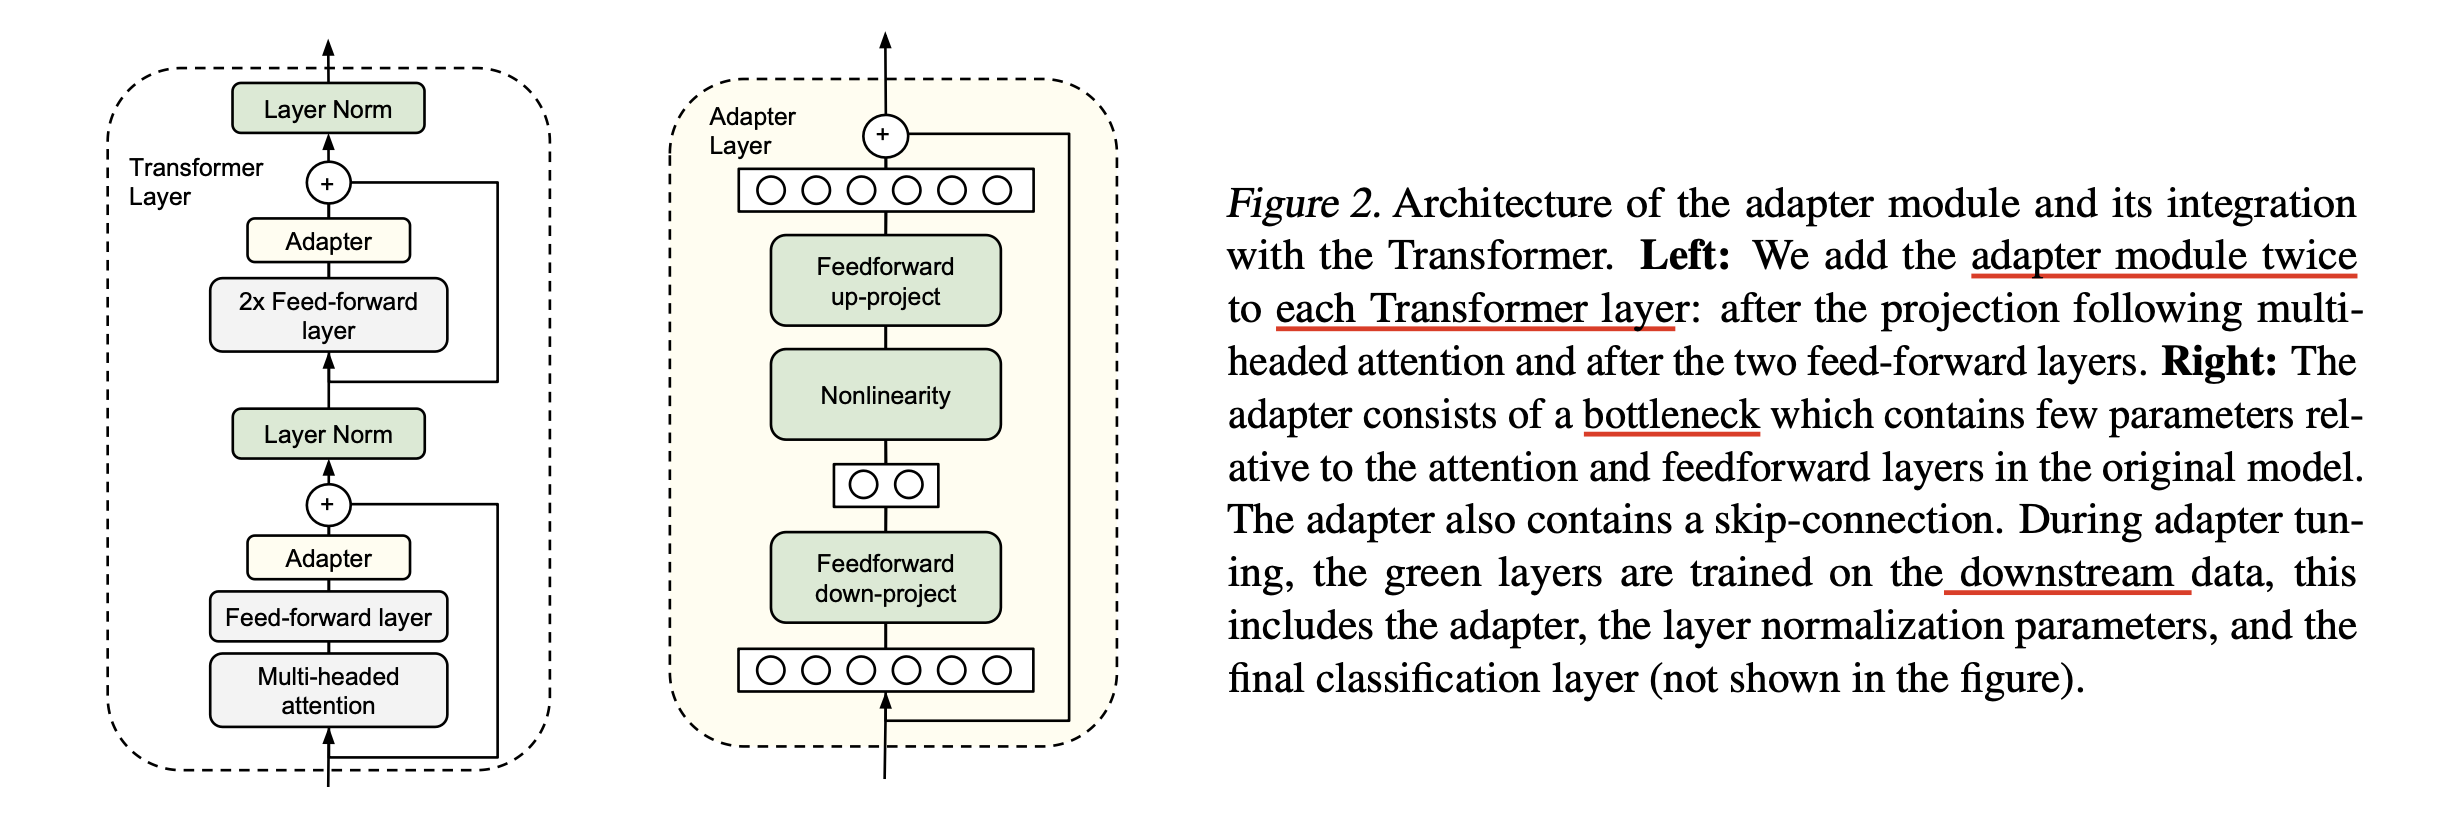

#### 🌟 Distributed and Parallel Infrastructures
- Types of Parallelism
  - Model Parallelism
  - Data Parallelism
- Concurrency of Data Parallelism Training
  - Synchronous
    - Parameters Distribution and Communication
      - Centralized
      - Decentralized
  - Asynchronous


### 2. Directly optimize prompt is hard.
- Prefix Tuning Working Pattern
  - Prefix consists of *free parameters* which not corresponding to real token.
  - We train task-specific upstream prefix, then downstream LM which remains unmodified.
  - Transformer LM need to be trained and copied once.
- Mathmetical Expression
  - $z_i$:
    - For autoregression LM: $z=[PREFIX;x;y]$
      - $x$: input source
      - $y$: task target
    - For encoder-decoder LM: $z=[PREFIX;x;PREFIX';y]$
  - $P_{idx}$: index of prefix sequence
    - $|P_{idx}|$: length of the prefix
  - Training objective log-likelihood functions:
    - $max_{\theta} \space logp_{\theta}(y|x)=\sum_{i∊Y_{idx}}logp_{\theta}(z_i|h_i)$
      - $\theta$: prefix parameters
      - $Y_{idx}$: sequence index corresponding to $y$
      - $h_i$: activation at time step $i$
  - Activation function:
    \begin{equation}
    h_i=\begin{cases}
    P_{\theta}[i,:], {if } \space i \in P_{idx}\\
    LM_{𝚽}(z_i,h_{<i}), otherwise
    \end{cases}
    \end{equation}
    - $P_{\theta}$:
      - trainable matrix with $|P_{idx}|$×dim($h_i$) dimension
      - to store prefix parameters
    - $LM_{𝚽}(z_i,h_{<i})$: a function of $z_i$ and past activations in left context
      - $h_i$: the last layer of it is used to compute distribution of next token
        - $p_{𝚽}(z_{i+1}|h_{<=i})=Softmax(W_{𝚽}h_i^{n})$
- Problems:
  - if we directly update prefix parameters, the model performance is unstable and sightly decline.
  - Solution: Parametrization $P_{\theta}$
    - mathmetical expression: $P_{\theta}[i,:]=MLP_{\theta}(P'_{\theta}[i,:])$
      - $P'_{\theta}[i,:]$: smaller prefix matrix which has same prefix length but different columns, compared with original one.
      - once training completed, reparametrized parameters will be *dropped*.
- Hyperparameter Tuning:
  - Training:
    - AdamW optimizer
    - Default setting:they may be adjusted by specific tasks
      - num_epochs=10
      - batch_size=5
      - learning_rate=$5*10^{-5}$
      - prefix_length=10
  - Decoding:
    - beam size $k$=5
      - normally, we set $k \in$ [1,10].
    - length_normalization $α$=0.8
    - beam search:
      - take best $k$ words
      - consider the probabilities of all preceding words combined with the selected word(the starting part token).
      - Disadvantage:
        - get stuck in local optima
        - doesn't consider the context of input, producing unnatrual output sequence.
- Notes:
  - if the prefix length is too long(>200 for summarization, >10 for table-to-text), the performance will decline.
  - trainable activation's position affects model performance:
    - infix-tuning underperforms prefix-tuning.
  - prefix initialization:
    - random initialization leads to low performance and high variance
    - initialize the prefix with activations of *real words* computed by LM and *task-relative* performs slight better than above.
- Advantages:
  - Prefix-tuning is a good choice for a large number of tasks that need to train independently.
  - preserve users' privacy without data cross-contamination.
- Disadvantages: can not take long input sequence.


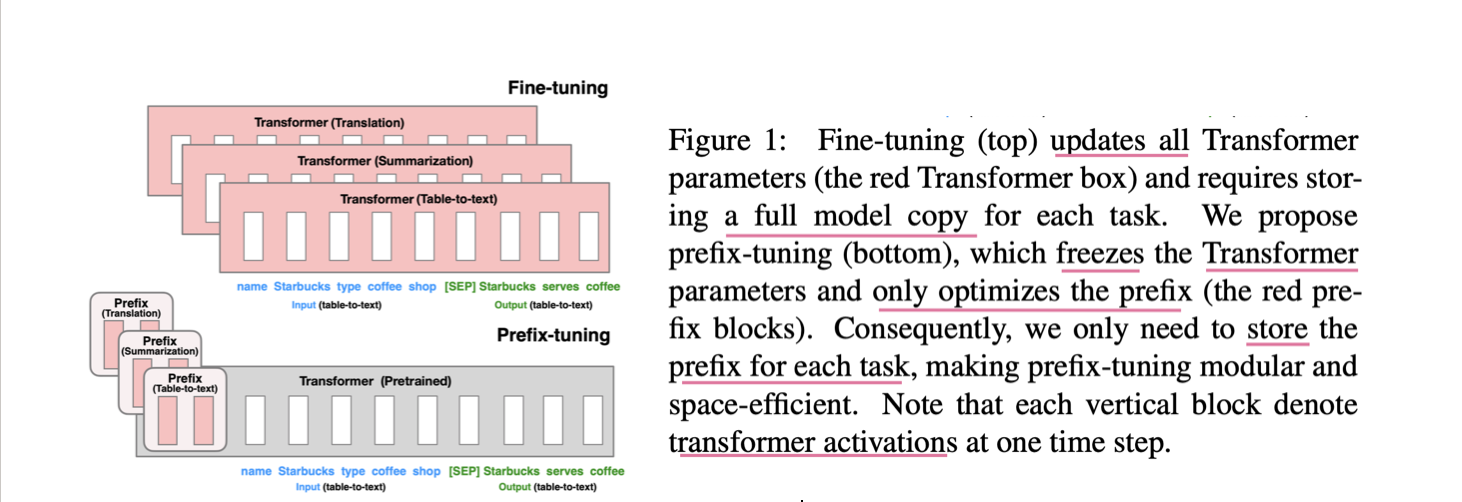

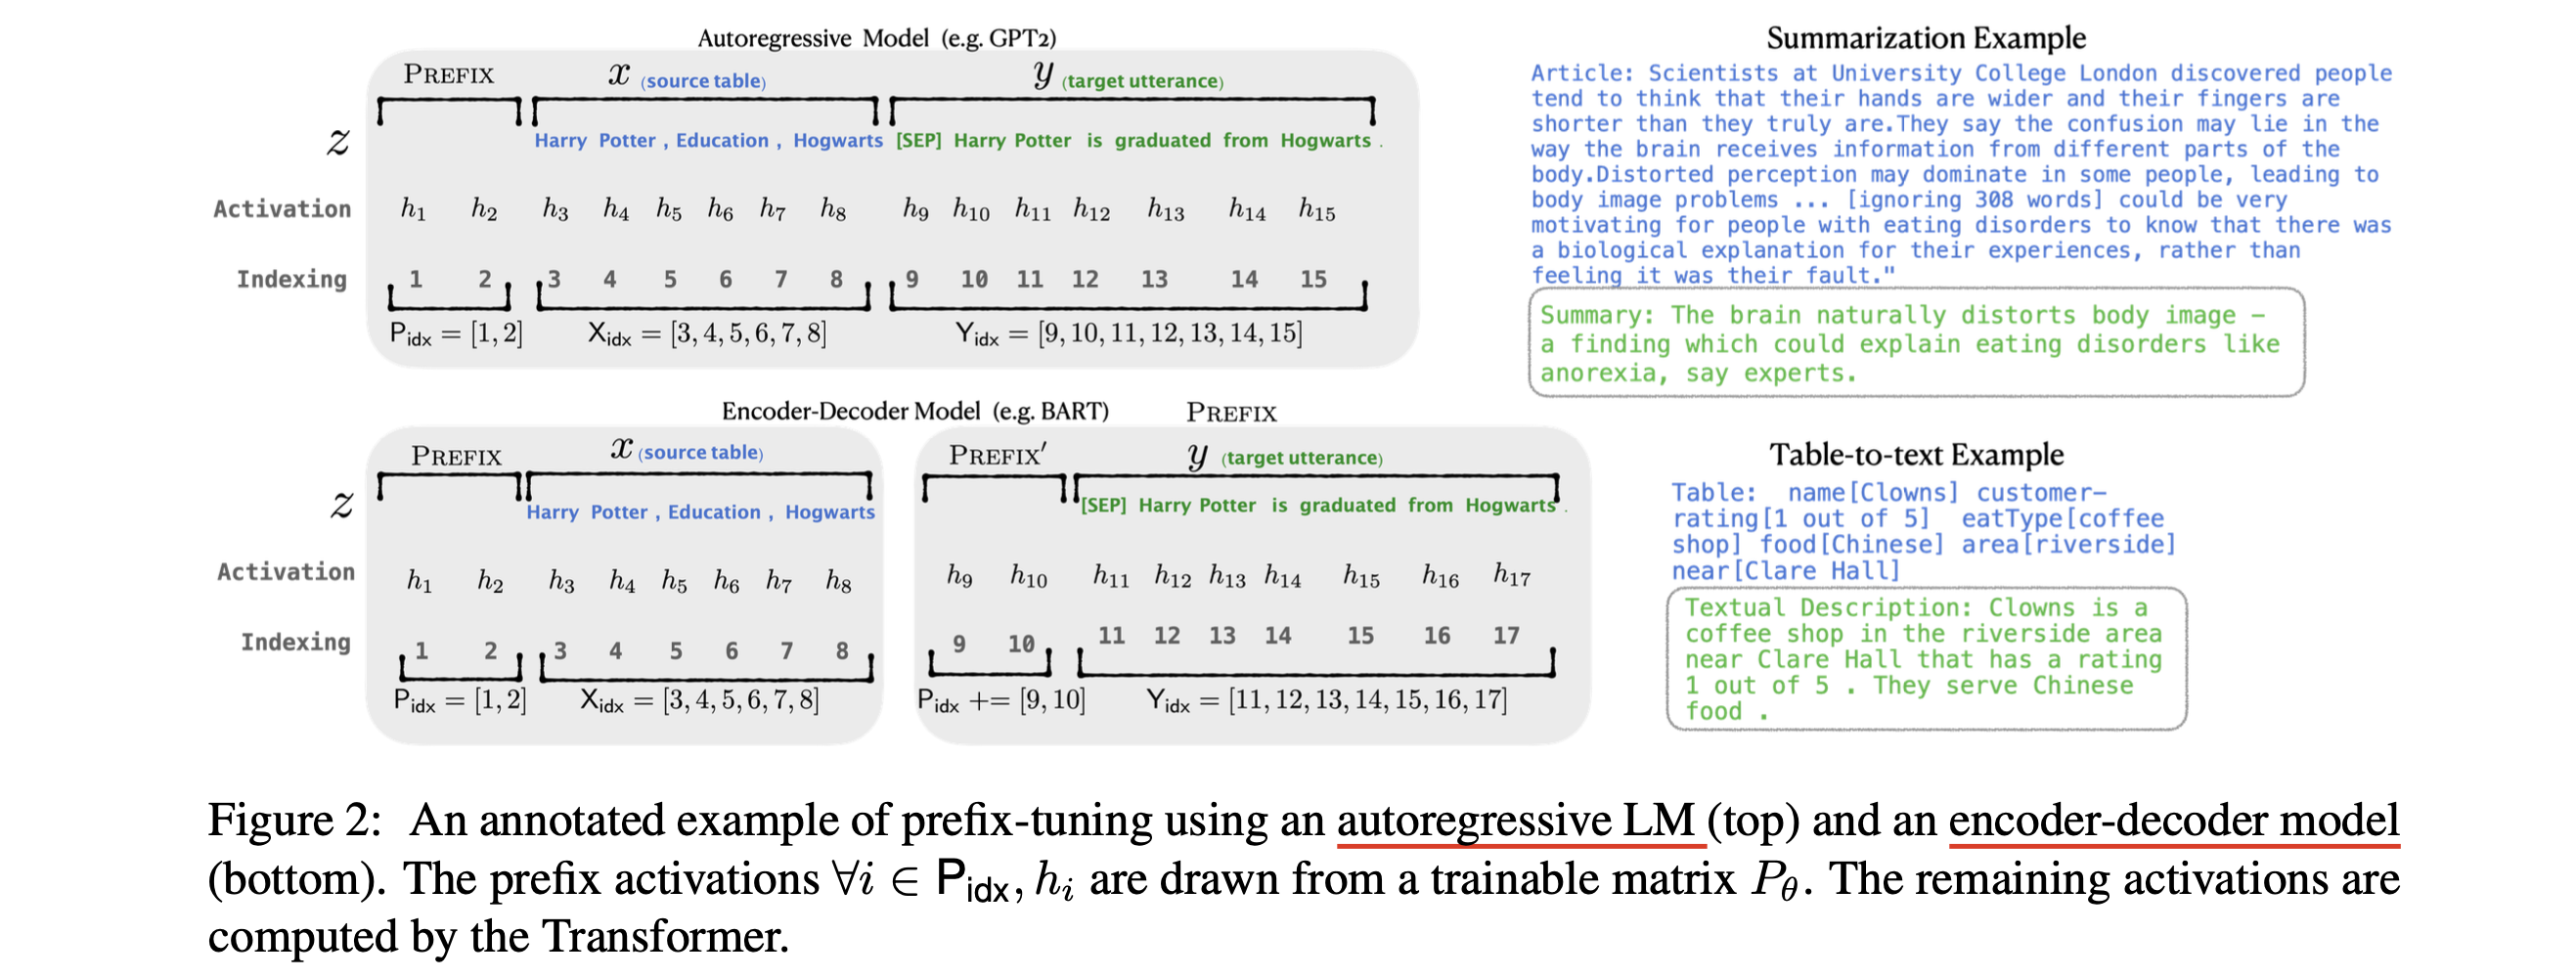

## 2. Architecture of LoRA
- Objective: maximum conditional probability given a task-specific prompt
  - $P_𝚽(y|x)$: represent transformer-based multi-tasks learner, parametrized by $𝚽$.
  - $Z=\left\{(x_i,y_i) \right\}_{i=1,2,...,N}$: context-target pairs, also can be understood as LLM's input and downstream task's output.
- Objective Function of Full Fine-Tuning:
  - $max_𝚽\sum_{(x,y)∊Z}\sum_{t=1}^{|y|}log(P_𝚽(y_t|x,y_{<t}))$
    - $P_𝚽$: trainable language model distribution
    - it performs gradient updates
  - $𝚽_0$→$𝚽_0+Δ𝚽$
  - drawbacks: for each downstream task, the learner should train a different set of parameters(Δ𝚽) whose dimensions equal to initial pre-trained weights($𝚽_0$), making deployment and storage difficult.
- Objective function of LoRA:
  - $max_𝚹 \sum_{(x,y)∊Z}\sum_{t=1}^{|y|}log(p_{𝚽_0}+Δ𝚽(𝚹)(y_t|x,y_{<t}))$
  - the number of trainable parameters $|𝚹|$= $0.01\%$ that of $|𝚽_0|$.
- Low-Rank-Parametrized Update Matrix
  - $h=W_0x+\Delta Wx=W_0x+BAx$
    - $B$: dimension($d*r$)
    - $A$: dimension($r*k$)
      - $r$<<$min(d,k)$
    - $h$: output
  - $W_0$ is frozed when training, while update $A$ and $B$. Set $BA$=$\Delta Wx$ *avoids inference latency*.
  - initialization: A, Gaussian initalization; B, Zero.
  - Optimizer: Adam
  - $\Delta Wx$ scaled by $\alpha/r$
    - Scale helps us to reduce retune hyperparameters when changing $r$
    - by default, we set $\alpha$ as the first $r$.
- Apply LoRA to Transformers
  - We have 4 weights in self-attention module and 2 weights matrix in MLP.
  - Dimension of $W_q$(or $W_k,W_v$)=$d*d$
  - freeze MLP modules and only updates downstream tasks' attention weights.


### Reparametrization
- Only $A$ and $B$ are trained.
- Notations:
  - $d$: the input output dimension size of a transformer layer
  - $W$ or $W_0$: pretrained weight matrix
  - $ΔW$: accumulated gradient update during adaptation
  - $r$: rank of a LoRA model
  - $W_q, W_k, W_v, W_o$: the query, key, value, output **projection matrices** in self-attention.
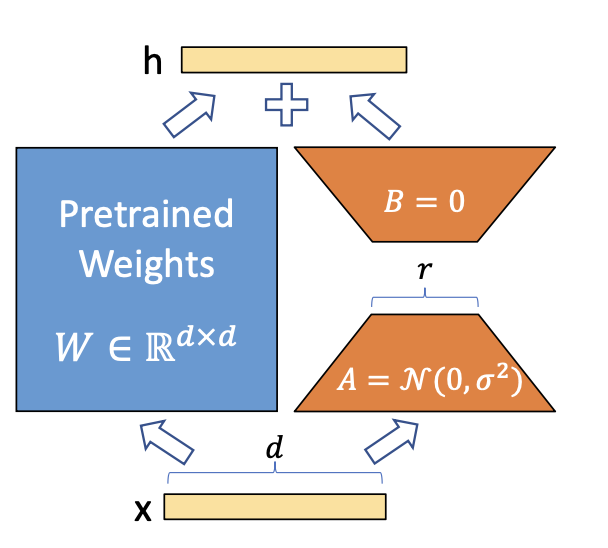


- The weights matrix in Transformer applied LoRA:
  - $r$=8, if we choose one type of the four
  - $r$=4, if we choose two types of the four
  - $r$=8, if we choose all of the four
  - when $r$=4, it contains enough information about $\Delta W$
- The optimal Rank $r$ for LoRA:
  - a very small $r$ is enough to perform well, but plz not over 8.
  - increasing $r$ cannot improve the coverage of meaningful space.
    - Proof: $r=64$ and $r=8$ do not have common singular value directions in random Gaussion matrix.When $r$=1, the common overlap up to the maximum.
- The relationship between $\Delta W$ and $W$
  - Using SVD, $W→\Delta W$ with $r$ dimension,by computing $U^TWV^T$.
    - $U,V$: left,right singular vector matrix of $\Delta W$
    - small $k$ makes SVD low-rank
    - the choice of $r$ is a balance of model complexity and performance.
  - Take F2 norm of SVD multiplication and $W$, denoted as $||...||_F$
    - Compute SVD multiplication by replacing $U$, $V$ with top $r$ dimensional singular vectors of $W$ or a random matrix.
  - The results show that compared with random matrix, $ΔW$ has a stronger correlation with $W$.


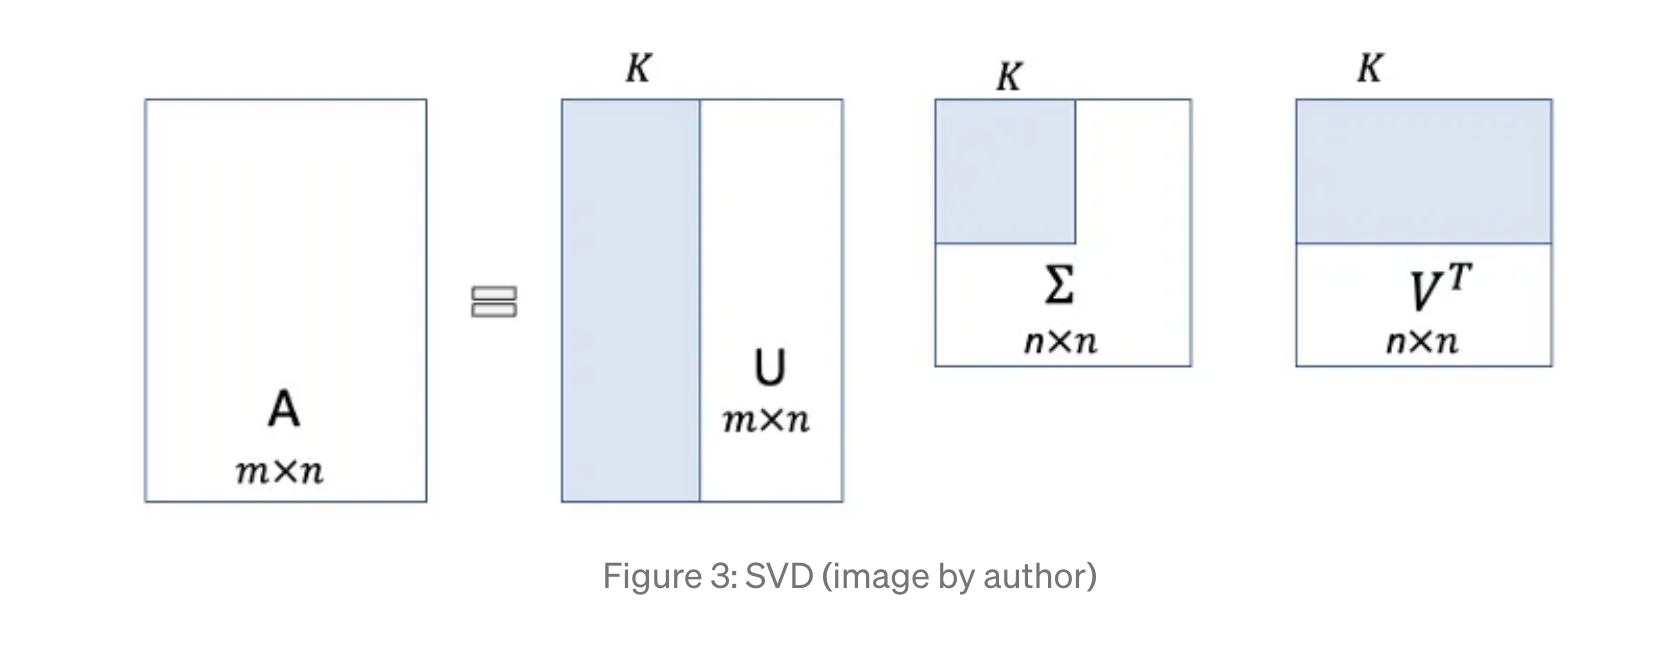

## 3. Advantages of LoRA
- reduce number of trainable parameters
- reduce the need of GPU, RAM memory requirement, allows us to train multiple experiments in parallel.
  - Using `adaptive optimizer` without gradients calculation or maintaining parameters' optimizer states
- <u>pretrained model can be shared & freezed</u> for building different LoRA modules for different tasks. Tasks switching is realized by matrix $A$ and $B$ exchange.
- Using simple *linear design* to <u>combine trainable metrics with frozen weights</u> results in *no inference latency*, compared to fully fine-tune.
  - Inference Latency: the time our model takes to make prediction after fed the input data.

## 4. Coding Example with GPT

In [ ]:
!pip install loralib
!pip install peft
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.5 MB/s eta 0:00:00
